In [5]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd())) # Add parent directory to path

# Import required libraries
import torch 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from model import VAE
import pandas as pd

## import model

In [7]:
# Model parameters
input_dim = 13125
hidden_dim = 256
latent_dim = 32
batch_size = 2048

# Load the model and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize and load the model (plant distribution model)
model = VAE(input_dim, hidden_dim, latent_dim, input_dim).to(device)
model_path = '../model/model_all_regions.pth'
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)

# Function to process data in batches
def apply_model(model, data, batch_size=2048, device='cuda'):
    """
    Apply the VAE model to input data in batches
    
    Args:
        model: The VAE model
        data: Input tensor data
        batch_size: Size of batches to process
        device: Computing device (cuda/cpu)
    
    Returns:
        Concatenated tensor of reconstructed data
    """
    model.eval()
    num_samples = data.size(0)
    recon_x_list = []

    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch = data[i:i+batch_size].to(device)
            batch_recon_x, _, _ = model(batch)
            recon_x_list.append(batch_recon_x.cpu())

    return torch.cat(recon_x_list, dim=0)

Using device: cpu


### import data and apply the model

In [8]:
# Load input data, plant distribution data with 561 grids
input_data = torch.FloatTensor(np.load('../data/interpolation/interpolation_input.npy'))
print(f"Input data shape: {input_data.shape}")

# Apply the model
results = apply_model(model, input_data, batch_size=batch_size, device=device)
print(f"Results shape: {results.shape}")

# Save results
output_file = '../data/interpolation/interpolation_results.npy'
np.save(output_file, results.numpy())
print(f"Results saved to {output_file}")

Input data shape: torch.Size([561, 13125])
Results shape: torch.Size([561, 13125])
Results saved to ../data/interpolation/interpolation_results.npy


### visualize interplated data

Number of genera: 13125


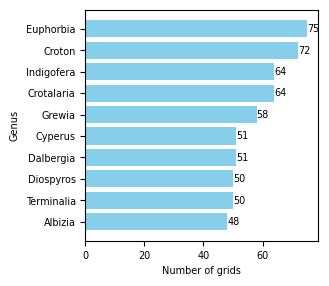

In [29]:
# Load genus list for visualization
genus_list = np.load('../data/interaction/genus_list.npy', allow_pickle=True).item()
genus_name = np.array([key for key, value in genus_list.items()])
print(f"Number of genera: {len(genus_name)}")

# Process results for visualization
results_array = results.numpy()
prob_mask = results_array > 0.5
genus_counts = prob_mask.sum(axis=0)  # Count occurrences per genus

## Get top 10 genera by count
top_10_indices = np.argsort(genus_counts)[-10:][::-1]  # Reverse to get descending order
top_10_genera = genus_name[top_10_indices]
top_10_counts = genus_counts[top_10_indices]

# Create horizontal bar plot
plt.figure(figsize=(3, 3))
bars = plt.barh(range(len(top_10_genera)), top_10_counts[::-1], color='skyblue')

# Customize the plot
plt.xlabel('Number of grids', fontsize=7)
plt.ylabel('Genus', fontsize=7)

# Set genus names on y-axis
plt.yticks(range(len(top_10_genera)), top_10_genera[::-1], fontsize=7)

# Set x-axis tick label size
plt.xticks(fontsize=7)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{int(width)}',
             ha='left', va='center', fontsize=7,
             bbox=dict(facecolor='none', edgecolor='none', alpha=0.7))
plt.show()
